In [1]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# FUNCTIONS DEFINED HERE: GAUSSIAN KERNEL, BETA CALCULATOR, THE S, D and L MATRICES CALCULATORS

def gaussian_kernel(y1, y2, β1, β2):
    return np.exp(-np.linalg.norm(y1 - y2)**2 / (β1 * β2))

def compute_β(V, y, M):
    assert M <= len(V), "M must be at most len(V)"
    norm_list = np.array([np.linalg.norm(vi-y) for vi in V])
    norm_list = norm_list[norm_list > 0]
    norm_list.sort()
    return np.sum(norm_list[:M]) / M

def compute_similarity_matrix(similarity_function="gaussian", **kw_args):
    if similarity_function=="gaussian":
        V, M = kw_args["compute_β"]
        N = len(V)
        res = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1, N):
                βi = compute_β(V, V[i], M)
                βj = compute_β(V, V[j], M)
                loc_value = gaussian_kernel(V[i], V[j], βi, βj)
                res[i, j] = loc_value
                res[j, i] = loc_value
        return res
    else: #p-value
        pass

def compute_D(similarity_matrix):
    return np.diag(np.sum(similarity_matrix, axis=1))

def compute_lagrangian(similarity_function="gaussian", **kw_args):
    S = compute_similarity_matrix(similarity_function=similarity_function, **kw_args)
    D = compute_D(S)
    return D - S

In [3]:
# THE HISTOGRAM HEURISTIC FUNCTION

# test_bins is the value that you can fit, which is a segmentation of the interval so that you can
# discriminate between a noise and an identity vector

def get_ker_vec_hist_heuristic(eig_vec, test_bins):
  res = []
  N = eig_vec.shape[0]
  for i in range(N):
    count, bins = np.histogram(eig_vec[:, i], bins=test_bins)
    test_value = len(count[count != 0])
    if test_value <= 3:
      res.append(eig_vec[:, i])
  return np.array(res)

In [4]:
# OBSERVATION FUNCTION DEFINITION
def observe_smooth_circles(ns, *R):
    nR = len(R)
    thres = ns // nR
    res = np.zeros((thres * nR, 2))
    for i in range(ns):

        θ = np.linspace(0, 2*np.pi, thres)

        for i in range(thres * nR):
            iR = i//thres
            iθ = i % thres
            res[i, 0] = R[iR] * np.cos(θ[iθ])
            res[i, 1] = R[iR] * np.sin(θ[iθ])
    return res

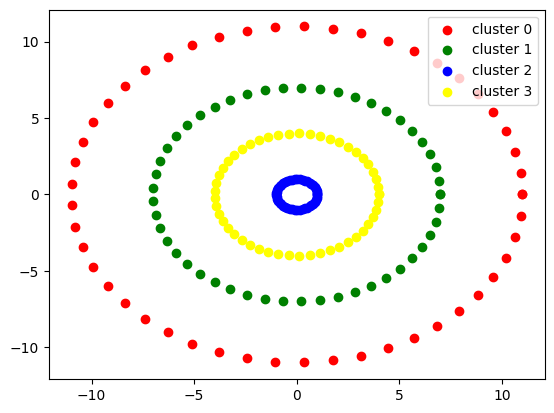

In [6]:
# DEFINITION OF OBSERVATIONS
obs = observe_smooth_circles(200,1,4, 7, 11)
kw = {"compute_β":[obs, 3]}

# COMPUTATION OF LAGRANGIAN AND EIGEN VECTORS
L = compute_lagrangian(**kw)
eig_val, eig_vec = np.linalg.eig(L)

# ESTIMATION OF THE EIGEN VECTORS FROM THE KERNEL OF L
test_bins = 10
res_eig = get_ker_vec_hist_heuristic(eig_vec, test_bins)

# GET THE SUBSEQUENT CLASSES
K = len(res_eig)
km = KMeans(n_clusters=K, n_init='auto')
km.fit(res_eig.T)
classes = km.predict(res_eig.T)

# SHOW THE RESULT
nb_classes = K
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]

for i in range(nb_classes):
    Aauto = obs[classes==i]
    plt.scatter(Aauto[:, 0], Aauto[:, 1], c=colors[i], label=f"cluster {i}")
plt.legend()